# CLIP-guided Diffusion — Lightweight Prototypes

Objective: prototype text-driven image generation and style-transfer using CLIP guidance to inform early product demos.

**Contents**
1. Environment & safety note
2. Text-to-image prototype
3. Image-to-image (style transfer) prototype
4. Observations & limitations


In [24]:
# %% Environment (enable the pip line on Colab if imports fail)
# !pip -q install diffusers==0.30.0 transformers==4.44.2 accelerate==0.34.2 safetensors xformers==0.0.27.post2
from typing import Optional
import torch
from PIL import Image
from pathlib import Path
from datetime import datetime
from IPython.display import display

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('DEVICE:', DEVICE, '| CUDA OK:', torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print('GPU:', torch.cuda.get_device_name(0))
    except Exception:
        pass

DEVICE: cpu | CUDA OK: False


### Safety & licensing
- Use models in accordance with their licenses and terms.
- Add a basic prompt/NSFW filter when exposing a public UI.


In [25]:
# --- Safe save + display (always renders as static PNG, no widgets) ---
from pathlib import Path
from datetime import datetime
from IPython.display import Image as IPyImage, display
import io

OUTDIR = Path('/content/outputs') if Path('/content').exists() else Path('outputs')
OUTDIR.mkdir(parents=True, exist_ok=True)

def save_and_show(img, prefix: str = 'gen') -> str:
    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    path = OUTDIR / f"{prefix}_{ts}.png"
    img.save(path)

    # display as raw PNG bytes to avoid any widget-view metadata
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    display(IPyImage(data=buf.getvalue()))

    print("Saved →", path)
    return str(path)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

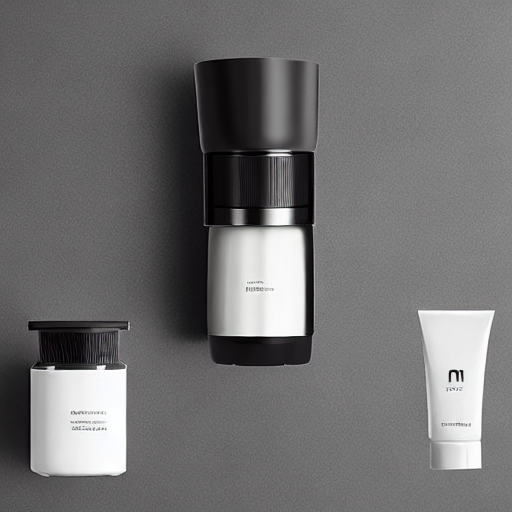

Saved → /content/outputs/t2i_20251026_233902.png


In [26]:
# %% Text-to-image (Stable Diffusion v1.5) — cached pipeline
from diffusers import StableDiffusionPipeline
_TXT2IMG = None

def get_txt2img():
    global _TXT2IMG
    if _TXT2IMG is None:
        kw = {}
        if DEVICE == 'cuda':
            kw['torch_dtype'] = torch.float16
        _TXT2IMG = StableDiffusionPipeline.from_pretrained(
            'runwayml/stable-diffusion-v1-5', **kw
        ).to(DEVICE)
        if DEVICE == 'cuda':
            try:
                _TXT2IMG.enable_xformers_memory_efficient_attention()
            except Exception:
                pass
    return _TXT2IMG

def generate(prompt: str, steps: int = 35, guidance: float = 7.5, seed: Optional[int] = 1234,
             negative: str = 'nsfw, nude, watermark, text, logo') -> Image.Image:
    pipe = get_txt2img()
    g = torch.Generator(device=DEVICE).manual_seed(seed) if seed is not None else None
    out = pipe(prompt, num_inference_steps=steps, guidance_scale=guidance,
               negative_prompt=negative, generator=g)
    return out.images[0]

# Demo run (enabled)
DO_RUN_T2I = True
if DO_RUN_T2I:
    img = generate('product mockup, clean studio lighting, minimal background, 50mm photo')
    save_and_show(img, prefix='t2i')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

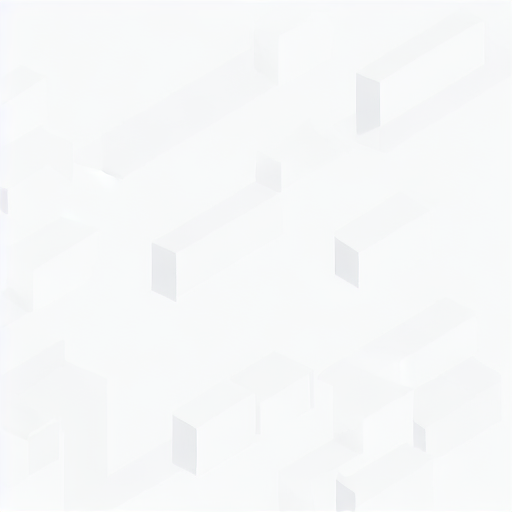

Saved → /content/outputs/i2i_20251026_235355.png


In [27]:
# %% Image-to-image (style nudging) — cached pipeline
from diffusers import StableDiffusionImg2ImgPipeline
_I2I = None

def get_img2img():
    global _I2I
    if _I2I is None:
        kw = {}
        if DEVICE == 'cuda':
            kw['torch_dtype'] = torch.float16
        _I2I = StableDiffusionImg2ImgPipeline.from_pretrained(
            'runwayml/stable-diffusion-v1-5', **kw
        ).to(DEVICE)
        if DEVICE == 'cuda':
            try:
                _I2I.enable_xformers_memory_efficient_attention()
            except Exception:
                pass
    return _I2I

def stylize(init_img: Image.Image, prompt: str, strength: float = 0.6, steps: int = 35,
            guidance: float = 7.5, seed: Optional[int] = 1234) -> Image.Image:
    pipe = get_img2img()
    g = torch.Generator(device=DEVICE).manual_seed(seed) if seed is not None else None
    out = pipe(prompt=prompt, image=init_img, strength=strength,
               num_inference_steps=steps, guidance_scale=guidance, generator=g)
    return out.images[0]

# Demo run (enabled)
DO_RUN_I2I = True
if DO_RUN_I2I:
    base = Image.new('RGB', (512, 512), 'white')
    out = stylize(base, 'isometric icon style, soft gradients, crisp edges')
    save_and_show(out, prefix='i2i')

## Observations
- For quick demos, a single A10G/T4 is adequate; batch size 1, 512x512.
- Prompt engineering matters more than step counts for early concept checks.
- For consistent branding, keep a small prompt library checked into the repo.

## Next steps
- Wire a basic Streamlit UI to collect prompts and seed; export PNGs.
- If going beyond prototype, consider ControlNet or fine-tuning for product styles.
